# Landscape Evolution Modeling

An (almost real world) example of how we can use xarray-simlab for landscape evolution modeling.

In [1]:
import numpy as np
import xarray as xr
import xrsimlab

## Import and inspect a model

The model (i.e., the `xrsimlab.Model` object) that we use here is provided by the [xarray-topo](https://gitext.gfz-potsdam.de/sec55-public/xarray-topo) package.

In [2]:
from xrtopo.models.fastscape_base import fastscape_base_model

This 2-dimensional model simulates the long-term evolution of topographic surface elevation (hereafter noted $h$). The local rate of elevation change, $\partial h/\partial t$, is determined by the balance between uplift (uniform in space and time) $U$ and erosion $E$.

$$\frac{\partial h}{\partial t} = U - E$$

Erosion (river channels) is given by the stream power law:

$$E = K A^m (\nabla h)^n$$

where $A$ is the drainage area and $K$, $m$ and $n$ are parameters.

We can see these parameters - as well as the initial elevation surface and the grid parameters - as model inputs in the `repr`.

In [3]:
fastscape_base_model

<xrsimlab.Model (9 processes, 13 inputs)>
grid
    x_size     (in) nb. of nodes in x
    y_size     (in) nb. of nodes in y
    x_length   (in) total grid length in x
    y_length   (in) total grid length in y
    x_spacing  (in) node spacing in x
    y_spacing  (in) node spacing in y
    x_origin   (in) grid x-origin
    y_origin   (in) grid y-origin
boundaries
uplift
    u_coef     (in) uplift rate
flow_routing
area
spower
    k_coef     (in) stream-power constant
    m_exp      (in) stream-power drainage area exponent
    n_exp      (in) stream-power slope exponent
erosion
exhumation
topography
    elevation  (in) topographic elevation

To have a better picture of all processes (and inputs and/or variables) in the model, we can visualize it as a graph. Processes are in blue and inputs are in yellow.

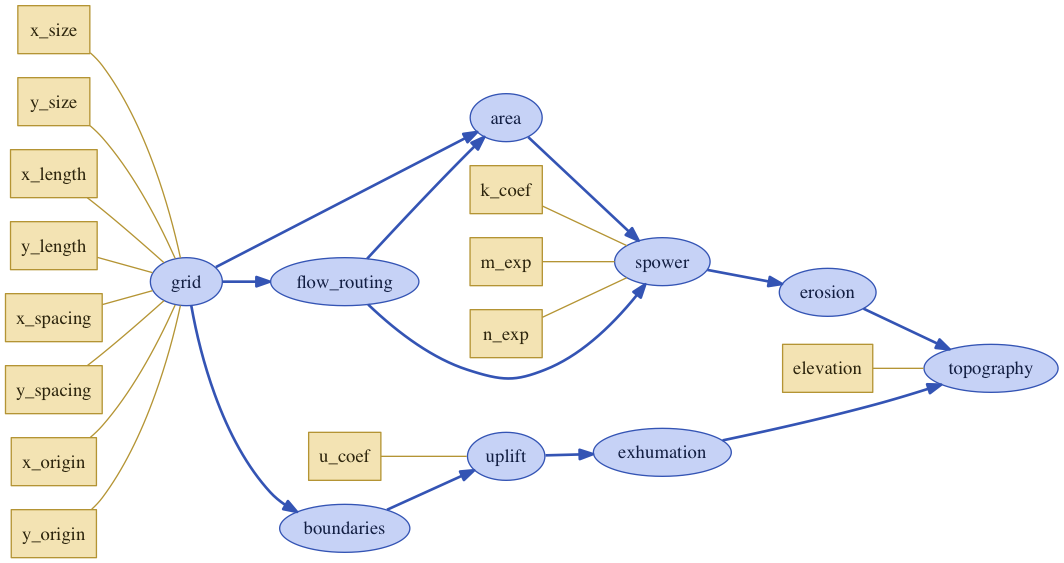

In [4]:
fastscape_base_model.visualize(show_inputs=True)

Note that in this model the 2-dimensional grid is actually stacked on the 'node' dimension, as shown below for the `x` and `y` variables. This is required by some of the algorithms implemented in it.

In [5]:
fastscape_base_model.grid

<xrsimlab.Process 'xrtopo.models.fastscape_base.StackedGridXY'>
Variables:
    x_size     IntegerVariable ()
    y_size     IntegerVariable ()
    x_length   FloatVariable ()
    y_length   FloatVariable ()
    x_spacing  FloatVariable ()
    y_spacing  FloatVariable ()
    x_origin   FloatVariable ()
    y_origin   FloatVariable ()
  * x          Variable ('node')
  * y          Variable ('node')
Meta:
    time_dependent: False

## Create a model setup

With a few lines of code we create the setup of a new simulation, starting from an empty `Dataset`.

In [6]:
# create a new Dataset
ds = xr.Dataset()   

# use the model above with this Dataset
ds.simlab.use_model(fastscape_base_model) 

# populate Dataset with input variable values (per process in the model)
ds.simlab.set_input_vars('grid', x_size=101, y_size=101, x_length=1e5, y_length=1e5)
ds.simlab.set_input_vars('topography', elevation=('node', np.random.rand(101 * 101)))
ds.simlab.set_input_vars('spower', k_coef=7e-5, m_exp=0.4, n_exp=1)
ds.simlab.set_input_vars('uplift', u_coef=2e-3)

# set the clock coordinate where labels are time steps (here in years)
ds.simlab.set_master_clock('time', end=1e6, step=1e3)

We want to save topography elevation values as output (snapshots), but not at every time step. 

In [7]:
# set another time coordinate for snapshots with much larger steps than for 'time'
ds.simlab.set_snapshot_clock('out', end=1e6, step=1e5)

# use the last created time coordinate to save topographic elevation values
ds.simlab.set_snapshot_vars('out', topography='elevation')

We also want to save the $x$ and $y$ coordinates of the grid.

In [8]:
# use None for saving time-independent outputs
ds.simlab.set_snapshot_vars(None, grid=['x', 'y'])

The Dataset now looks like

In [9]:
ds

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    topography__elevation  (node) float64 0.8926 0.2501 0.9166 0.4898 0.8683 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
Attributes:
    _simlab_snapshot_vars: grid__x,grid__y

## Run the model

We run the model simply by calling `Dataset.simlab.run()`, which returns a new Dataset with both the inputs and the outputs. Note the additional variables `grid__x` and `grid__y` and the `topography__elevation` variable which has now also the `out` dimension. 

In [10]:
out_ds = ds.simlab.run()

out_ds

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    topography__elevation  (out, node) float64 0.8926 0.2501 0.9166 0.4898 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
    grid__x                (node) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
    grid__y                (node) float64 0.0 0.0 0.0 0.0 0.0 0.0

## Analyse, plot and save the results

We can then use all the nice features of xarray to analyse, process, plot and/or write to disk (e.g., in a netCDF file) the simulation data obtained at the previous step.

In this case, before doing any further processing it is much more convenient to first represent the data using the two spatial dimensions. It is easily done with xarray:

In [11]:
out_ds_unstack = out_ds.set_index(node=['grid__x', 'grid__y']).unstack('node')

The resulting Dataset has no `node` dimension anymore but has `grid__x` and `grid__y` dimensions instead.  

In [12]:
out_ds_unstack

<xarray.Dataset>
Dimensions:                (grid__x: 101, grid__y: 101, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
  * grid__x                (grid__x) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
  * grid__y                (grid__y) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    topography__elevation  (out, grid__x, grid__y) float64 0.8926 0.8466 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002

We can then plot the data, e.g., the elevation values at the end of the simulation:

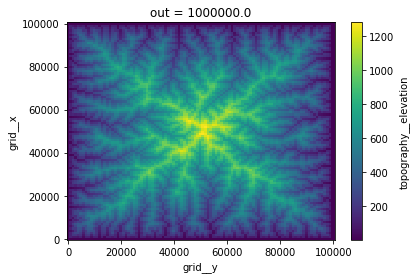

In [13]:
%matplotlib inline

xr.plot.pcolormesh(out_ds_unstack.isel(out=-1).topography__elevation);

xarray datasets can be used with [Holoview](http://holoviews.org/), a plotting package that is really helpful for quickly and interactively exploring multi-dimensional data.

In [14]:
import holoviews as hv

hv.notebook_extension('matplotlib')

We can for example see below how the relief is created during the simulation (snapshots are taken every 100000 years and elevation values are in meters). 

b':HoloMap   [out]\n   :Image   [grid__x,grid__y]   (topography__elevation)'
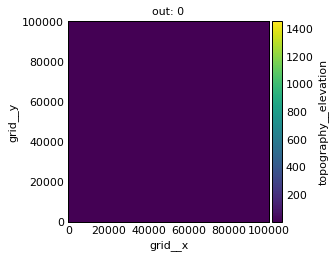
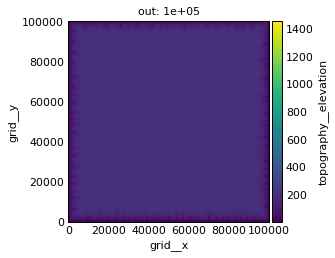
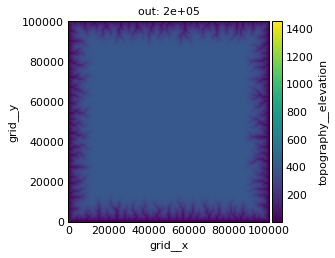
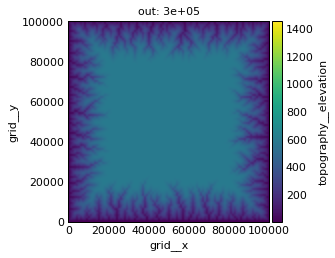
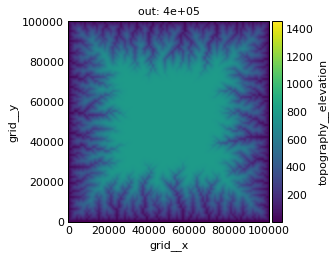
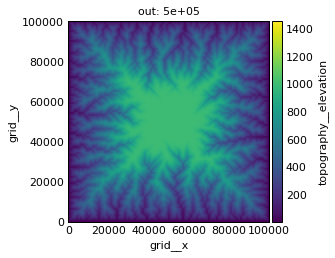
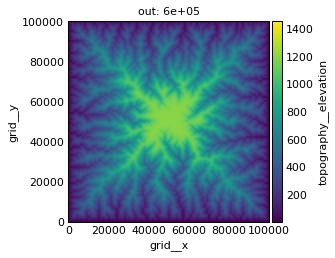
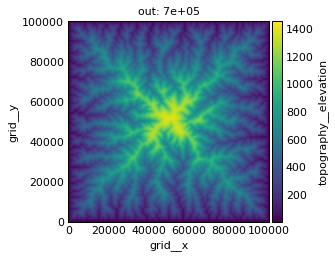
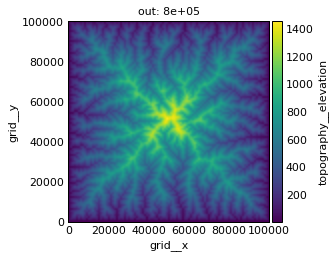
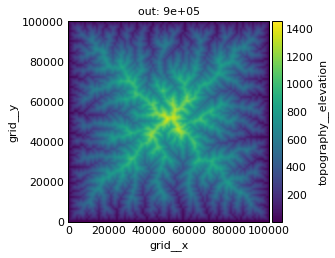
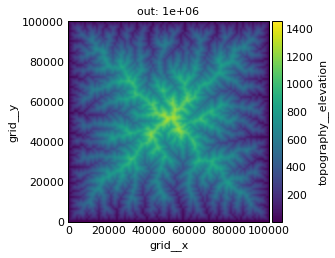

In [15]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_unstack.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])

Additionally, We can compute derived quantities without much effort. Here below we calculate the surface denudation rates averaged over each time steps of the output `out` dimension. 

In [16]:
da_dt = out_ds_unstack.out.diff('out')
den_rate = ((out_ds_unstack.topography__elevation.diff('out') / da_dt)
            - (out_ds_unstack.uplift__u_coef * da_dt))

We further compute and plot the spatially averaged denudation rate.

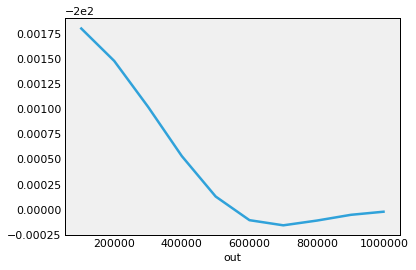

In [17]:
den_rate.mean(('grid__x', 'grid__y')).plot();

## Run and combine different model setups

Here is an brief example of running the model multiple times for different values of $K$ (stream power law) and then concatenate the results into a single dataset. In next versions of xarray-simlab, this process will be even simpler.

In [18]:
k_values = [5e-5, 6e-5, 7e-5]
datasets_k = []
    
ds_in = ds.copy()
ds_in.simlab.use_model(fastscape_base_model)

for k in k_values:
    print('run k=%f' % k)

    ds_in.simlab.set_input_vars('spower', k_coef=k, m_exp=0.4, n_exp=1)
    out_ds = ds_in.simlab.run()

    datasets_k.append(out_ds)

out_ds_concat = xr.concat(datasets_k, dim='spower__k_coef', data_vars='different')

run k=0.000050
run k=0.000060
run k=0.000070


We repeat the same operation than above to get back the data in 2 spatial dimensions. 

In [19]:
out_ds_concat_unstack = out_ds_concat.set_index(
    node=['grid__x', 'grid__y']).unstack('node')

Note the additional `spower__k_coef` dimension, which has its own index coordinate with labels corresponding to the $K$ values.

In [20]:
out_ds_concat_unstack

<xarray.Dataset>
Dimensions:                (grid__x: 101, grid__y: 101, out: 11, spower__k_coef: 3, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
  * spower__k_coef         (spower__k_coef) float64 5e-05 6e-05 7e-05
  * grid__x                (grid__x) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
  * grid__y                (grid__y) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
    topography__elevation  (spower__k_coef, 

This new dimension also appears in the Holoview figure

b':HoloMap   [out,spower__k_coef]\n   :Image   [grid__x,grid__y]   (topography__elevation)'
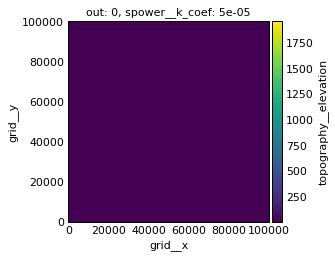
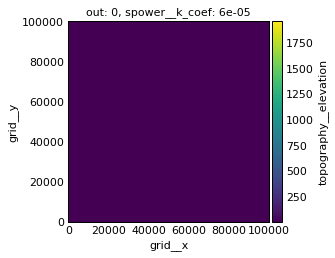
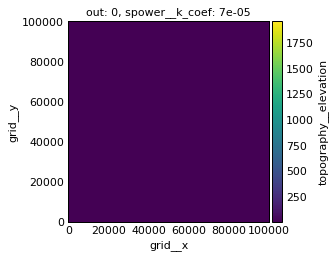
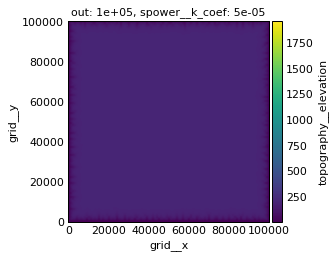
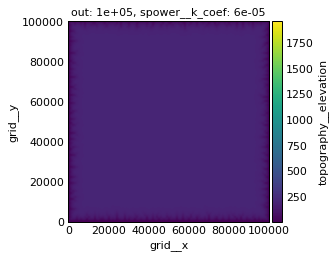
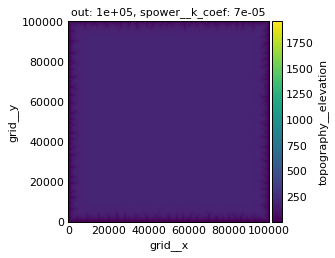
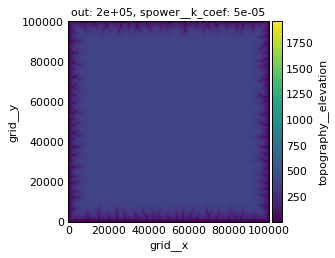
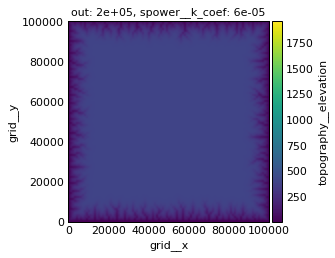
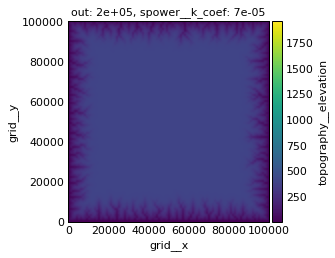
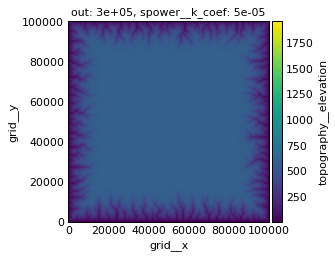
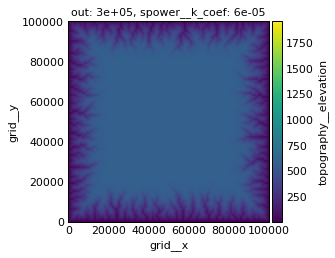
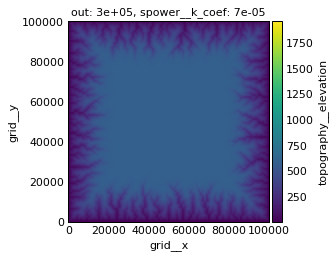
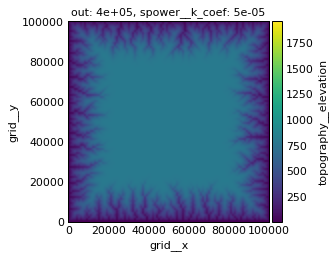
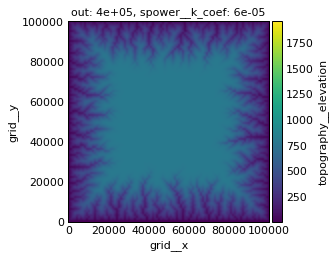
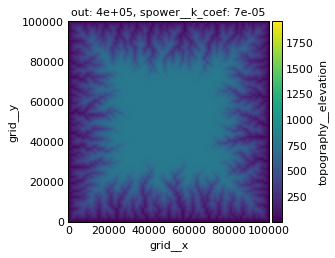
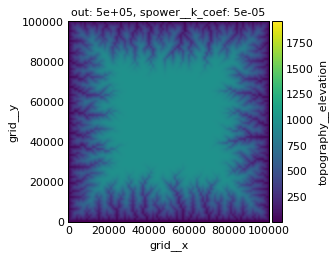
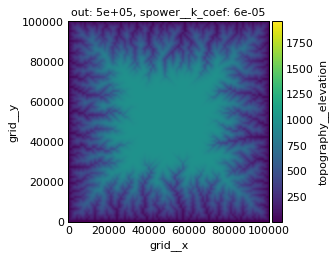
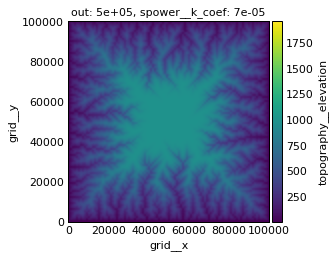
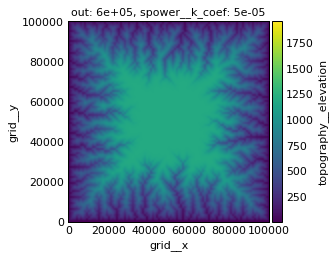
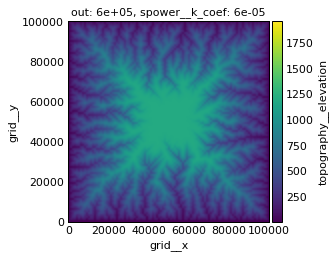
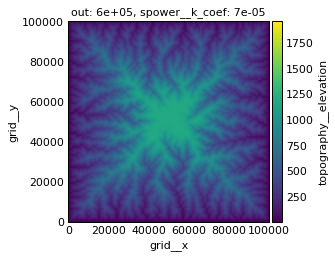
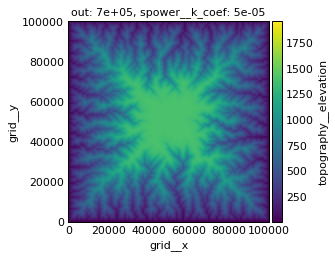
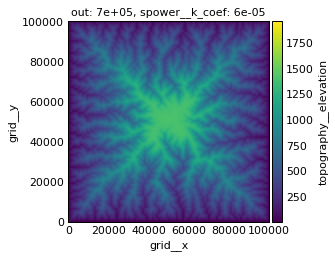
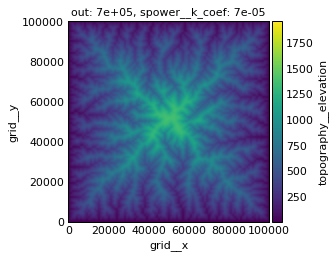
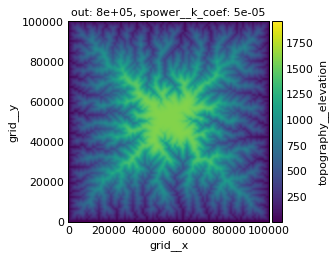
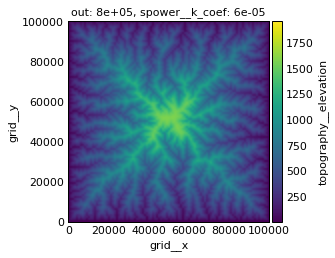
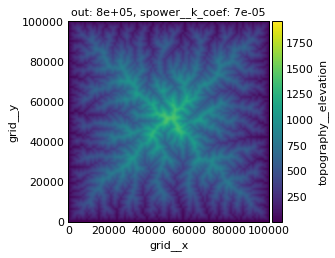
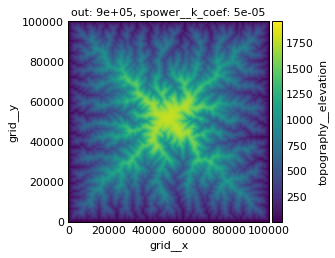
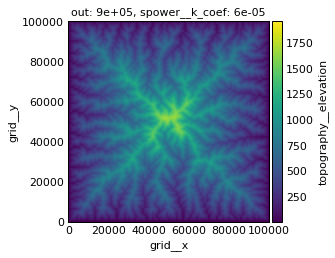
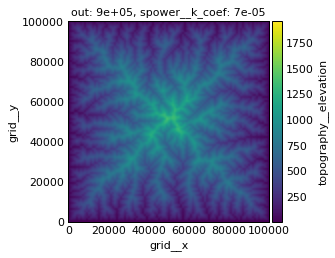
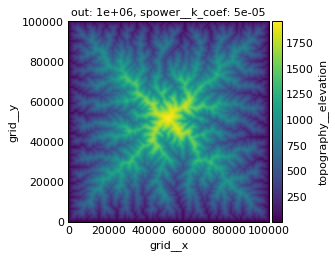
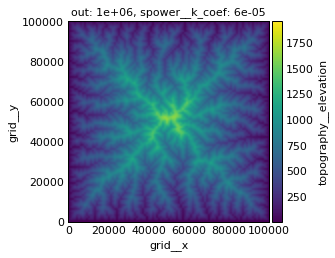
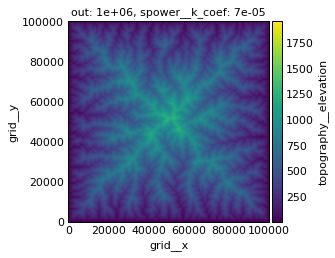

In [21]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_concat_unstack.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])